[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 


### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/NeuralNetworkEconomics.jl). The same
document generates both static webpages and associated [jupyter
notebook](slp.ipynb). 

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end
# Make gr backend work with λ and other unicode
ENV["GKS_ENCODING"] = "utf-8"

using NeuralNetworkEconomics
docdir = normpath(joinpath(dirname(Base.pathof(NeuralNetworkEconomics)), "..","docs"))
modeldir = normpath(joinpath(docdir,"jmd","models"))
if !isdir(modeldir)
  mkdir(modeldir)
end

using Pkg
Pkg.activate(docdir)
Pkg.instantiate()

  Activating project at `~/.julia/dev/NeuralNetworkEconomics/docs`


# Introduction

[The previous notes](mlp.md) discussed multiple layer feedforward
networks, and applied them to image classification. However,
state-of-art image classifiers typically do not use feedforward
networks. They use convolutional networks, which will be the topic of
this document. Convolutional neural networks also have applications to
PDEs, see @rackauckas2019conv. They also have potential applications
to time series and spatial data.

## Additional Reading

- @goodfellow2016 [*Deep Learning*](http://www.deeplearningbook.org)
  especially chapter 9
- [`Knet.jl`
  documentation](https://denizyuret.github.io/Knet.jl/latest/)
  especially the textbook
- @klok2019 *Statistics with Julia:Fundamentals for Data Science,
  MachineLearning and Artificial Intelligence*
    
  
# Convolutions

A convolution is an operation on a set of functions. If $f:\R \to \R$
and $g:\R \to \R$, then their convolution is
$$
(f \ast g)(x) = \int_\R f(t) g(x-t) dt
$$
The convolution is commutative, $(f\ast g)(x) = (g\ast f)(x)$. For
functions with other domains, convolutions can be defined
analogously. For example, for $f, g: \mathbb{Z} \to \R$, 
$$
(f \ast g)(j) = \sum_{i \in \mathbb{Z}} f(i)g(j-i)
$$

Kernel density estimation and regression are convolutions. For
example, the kernel density estimator can be written as
$$
\begin{align*}
\hat{f}(x) = & \frac{1}{nh} \sum_{i=1}^n k((x-x_i)/h) \\
= & \int \left(\frac{1}{n} \sum_{i=1}^n \delta_{x_i}(t) \right)k((x-t)/h)/h
dt
\end{align*}
$$
where $\delta_{x_i}(t)$ is the Dirac measure at $x_i$. 

Convolutions appear in image processing as blurring and smoothing
filters. Taking a local average of pixels is a convolution.

![convolution](https://hackernoon.com/hn-images/1*ZCjPUFrB6eHPRi4eyP6aaA.gif)

[Image source](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)

The similarity to kernel regression should be obvious. The 3x3 matrix 
```
1 0 1 
0 1 0 
1 0 1 
```
in the animation above is called a stencil or a kernel. 

In addition to blurring and smoothing, convolutions can detect patterns
in images. For example 1 × 2 filters of `[-1 1]` and `[1, -1]` will
pick out vertical transitions from dark to light and vice versa. 

Here's an illustration of how this looks using an image from the MNIST
data.

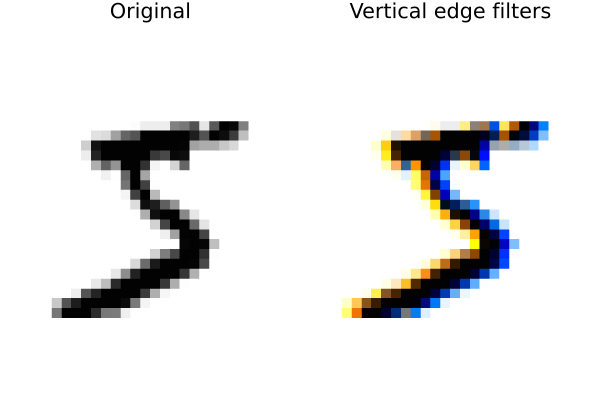

In [2]:
using MLDatasets
using ImageFiltering
using Plots

train_x, labels = MNIST(split=:train)[:]
imgs = [Gray.(train_x[:,:,i]') for i ∈ 1:size(train_x,3)]

i = 1
plot(plot(Gray.(1) .- imgs[i], title="Original", aspect_ratio=:equal,
          axis=false, ticks=false),
     plot(RGB.(1 .- imgs[i] .+ imfilter(imgs[i], centered([-1 1])),
               1 .- imgs[i],  
               1 .- imgs[i] .+ imfilter(imgs[i], centered([1 -1]))),
               title="Vertical edge filters", aspect_ratio=:equal,
          axis=false, ticks=false),
     layout=(1, 2)          
     )

In this image, the output of one edge filter is yellow, the other is
blue, and the original image is black.

From this example, we see that small hand-crafted convolution kernels
can pick out patterns, like edges. One idea would be to use the output
of these kernels as features in a machine learning model. Another idea
is to treat the weigths in a convolution matrix as part of the model
to be estimated. This is exactly what convolutional neural networks
do. 

# Example : MNIST

Let's see how convolutional neural networks can be applied to the
MNIST data.

<div class="alert alert-danger">
The code in this section was adapted from the [Flux model
zoo.](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl)
</div>

In [3]:
using Flux, MLDatasets, Statistics
using Flux: onehotbatch, onecold, throttle, @epochs
using Base.Iterators: repeated, partition
using JLD2
using ColorSchemes, ProgressMeter
cscheme = colorschemes[:BrBG_4];

When we were fitting feed-forward networks with this data, we simply
treated images as vetors of length $28^2$. That was appropriate there
because the model we were using did not explicitly utilize spacial
information. With convolutions, we need to preserve spatial
information, so we need to treat the images as $28 \times 28$ arrays.

In [4]:
# set up training and testing data
createx(imgdata) = reduce((x,y)->cat(x,y, dims=4),
                          reshape.(float.(imgdata),28,28, 1) )
X = Float32.(reshape(train_x, 28, 28, 1, size(train_x,3))) |> gpu
Y = onehotbatch(labels, 0:9) |> gpu
test_x, test_y = MNIST(split=:test)[:] 
tX = Float32.(reshape(test_x, 28, 28, 1, size(test_x,3))) |> gpu
tY = onehotbatch(test_y, 0:9) |> gpu;

When working with convolutions, `Flux.jl` wants the data to be stored
as a $K_1 \times K_2 \times C \times N$ array where $K_1 \times K_2$
is the dimension of the images (or whatever else the data represents),
$C$ is the number of channels. Since we have grayscale images, we have
one channel. Color images would have three channels. Radar and
satellite imagery can have more channels (satellites often collect
non-visible frequencies of light). 

Channels are also a useful abstraction throughout the neural
network. We usually want to apply multiple convolution filters to
extract different features of the images. The output of each
convolution is stored in a channel. 

Each convolution is intended to pick up some local pattern in the
image. It might be useful to modify certain pattens by applying an
activation function to the output of the convolution. 

Finally, convolutions detect patterns, but for many image
classification tasks, we do not necessarily care exactly where a
pattern occurs. A cat remains a a cat wherever it is located in a
picture. Motivated by this, a "pooling" operation is often applied to
the output of convolutions. These are similar to convolutions with
fixed weights. Common pooling operations include taking the average
within a rectangle of fixed size and taking the maximum. Pooling (and
convolution) can reduce dimension by only looking at non-overlapping
(or partially non-overlapping) regions. In `Flux.jl` the default for
convolutions is to look at every pixel, and the default for pooling is
to look at non-overlapping regions. This behavior can be changed by
changing the `stride` option. 

Mathematically, we can express a convolutional layer as follows. Let
$x$ be an $N \times N$ input channel, $\psi$ be an activation
function, $b \in \R$ is a bias, and $w$ be $M \times M$ convolution
weights, indexed from -M/2 to M/2. 

The result of applying the convolution is:
$$
\psi((x \ast w)[k,\ell]) = \psi\left(\sum_{i=1-P}^{N+P} \sum_{j=1-P}^{N+P}
x[i,j]*w[k-i, j - \ell] + b\right)
$$
where if an index is out-of-bounds simply set that term in the sum to
$0$. $P$ is the "padding". If $P=M/2$, then the size of $x\ast w$ is the
same as $x$. If $P<M/2$, the convolution decreases the size of the
image. Then if we apply a maximum pooling function with dimension $D \times D$,
we get a $N/D \times N/D$ array with elements
$$
maxpool(\psi((x \ast w) )[n,m] = \max_{1 \leq i \leq d, 1 \leq j \leq
d} \{\psi((x \ast w)[dk+i,d\ell+j])\} 
$$

The following code defines a convolutional network with three
convolutional layers followed by a dense feed-forward layer for the output.

In [5]:
model = Chain(
  # First convolution layer, operating upon a 28x28 image
  Conv((3, 3), 1=>16,  pad=(1,1), relu),
  MaxPool((2,2)),
  
  # Second convolution, operating upon a 14x14 image
  Conv((3, 3), 16=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  
  # Third convolution, operating upon a 7x7 image
  Conv((3, 3), 32=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  
  # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
  # which is where we get the 288 in the `Dense` layer below:
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10) #,
  
  # Finally, softmax to get nice probabilities
  #softmax
) |> gpu


# count parameters
nparam(m::Chain)=sum(nparam.(m))
nparam(m::Conv)=length(m.weight) + length(m.bias)
nparam(m::Dense)=length(m.weight)+length(m.bias)
nparam(m) = 0

println("There $(nparam(model)) parameters")

There 16938 parameters


Now, let's train the model. We are going to train the model a few
times with slightly different details, so it makes sense to define a
function for the training loop.

In [6]:
function accuracy(m, x, y)
  # onecold(m(x)) results in very slow code for large x, so we avoid it
  coldx = vec(map(x->x[1], argmax(m(x), dims=1)))  
  coldy = onecold(y)
  return(mean(coldx.==coldy))
end

function train_mnist!(model, X, Y, tX, tY,
                      modelname;
                      loss = (x,y)->Flux.logitcrossentropy(model(x), y),
                      accuracy = (x,y)->accuracy(model, x, y),
                      batchsize=length(tY),
                      reps_per_epoch=1,
                      maxepochs=200,
                      rerun=false
                      )
  Xsmall = X[:,:,:,1:1000]
  Ysmall = Y[:,1:1000]
  evalcb = () -> @show(loss(Xsmall, Ysmall), loss(tX,tY), accuracy(Xsmall,Ysmall), accuracy(tX,tY)) 
  parts=Base.Iterators.partition(1:size(X,ndims(X)), batchsize);
  batches = [(X[:,:,:,p], Y[:,p]) for p in parts];
  data = repeat(batches, reps_per_epoch);
  # The model and entire training data do not fit in my GPU
  # memory. For monitoring progress we will occassionally print the
  # loss and accuracy summed over the entire data.  
  function sumloss(batches)
    L = zero(Float32)
    for i in 1:length(batches)
      L += loss(batches[i]...)
    end
    L /= length(batches)
  end
  function acc(batches)
    L = zero(Float32)
    for i in 1:length(batches)    
      L += accuracy(batches[i]...)
    end  
    L /= length(batches)
  end
  
  opt = ADAM(0.001)
  acctest  = zeros(maxepochs)
  acctrain = zeros(maxepochs)
  losstest  = zeros(maxepochs)
  losstrain = zeros(maxepochs)  
  @info("Beginning training loop...")
  best_acc = 0.0
  last_improvement = 0
  e = 0
  docdir = joinpath(dirname(Base.pathof(NeuralNetworkEconomics)),
                    "..","docs")
  progress = Progress(maxepochs, 1, "Training model", 50)
  while e<maxepochs
    e += 1
    modelfile = joinpath(docdir,"jmd","models","$modelname-$e-epochs.jld2")
    if rerun || !isfile(modelfile)
      @time Flux.train!(loss, Flux.params(model), data, opt, cb = throttle(evalcb, 20))      
      # save model
      cpum = cpu(model)
      losstrain[e]= sumloss(batches)
      acctrain[e] =  acc(batches)
      losstest[e]=loss(tX,tY)
      acctest[e] =accuracy(tX,tY)
      @save modelfile cpum losstrain acctrain losstest acctest
    else 
      @load modelfile cpum losstrain acctrain losstest acctest
      model = gpu(cpum)
    end
    next!(progress)
    if (acctest[e]>best_acc)
      best_acc = acctest[e]
      last_improvement=e
    end    
    # If we haven't seen improvement in 3 epochs, we stop (could also
    # try droping learning rat but it would take time) we are cheating
    # here by using thest test accuracy as a stopping criteria ... 
    if ((e - last_improvement) >= 3) && (opt.eta <= 1e-6)
      @warn(" -> At epoch $e, haven't improved in 3 epochs. Stopping training.")
      break
    end
  end
  return(model=model,  
         losstrain=losstrain[1:e], acctrain=acctrain[1:e],
         losstest=losstest[1:e],   acctest=acctest[1:e])
end

train_mnist! (generic function with 1 method)

Now we train the model. We will begin by following a similar training
strategy as in the [previous notes.](mlp.md) That is, we will use
large batches and a low number of passes through the data per-epoch.

In [7]:
out = train_mnist!(model, X, Y, tX, tY, "conv";
                   batchsize=2500,
                   reps_per_epoch=2,
                   maxepochs=200,
                   rerun=false
                   )
@show maximum(out.acctest)

┌ Info: Beginning training loop...
└ @ Main In[6]:46
Training model 100%|██████████████████████████████████████████████████| Time: 0:00:04


maximum(out.acctest) = 0.99


0.99

Since I save the model to disk to avoid waiting for it to rerun
everytime I change this document, the above output does not include
the training time. It takes roughly 10 seconds per epoch.

In terms of testing accuracy, this model does quite well. The deep
feedforward network with nearly 12 million parameters from the
[previous notes](mlp.md), had an accuracy greater than 98%. The
convolutional network used here with 16 thousand parameters has a
accuracy of `j maximum(out.acctest)`%. The training time of
these two models was roughly the same.

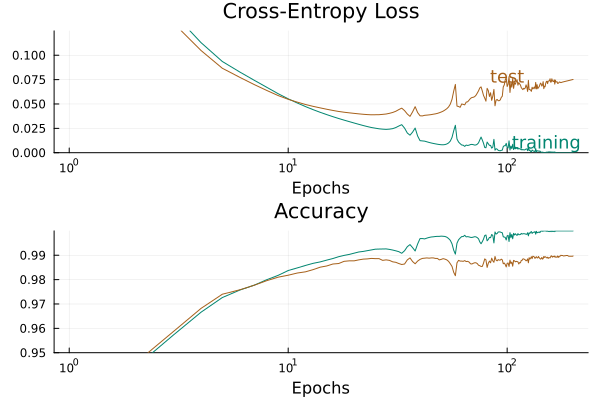

In [8]:
function training_plot(out) 
  ll = Int(round(length(out.losstrain)*0.75))
  lt = Int(round(length(out.losstrain)*0.5))
  plot(
    plot([out.losstrain, out.losstest], xscale=:log10, xlab="Epochs",
         title="Cross-Entropy Loss",
         ylims=(0.0, 0.125),
         annotations=[(ll, out.losstrain[ll],
                       Plots.text("training", pointsize=12, valign=:bottom,
                                  color=get(cscheme,1))),
                      (lt, out.losstest[lt],
                       Plots.text("test", pointsize=12, valign=:bottom,
                                  color=get(cscheme,0)))], leg=false,
         color_palette=get(cscheme,[1,0])
         ),
    plot([out.acctrain, out.acctest], xscale=:log10, xlab="Epochs",
         title="Accuracy",
         ylims=(0.95, 1.0),
         color_palette=get(cscheme,[1,0]), leg=false
         ),
    layout=(2,1)
  )
end
training_plot(out)

## Small Batches

If you look at the code in the [Flux model
zoo](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl)
for this model, it claims to achieve over 99% testing accuracy. The
code above is mostly identical to the model zoo, but it differs in two
ways. One is that the model zoo uses much smaller batches of 128
observations. The second is that the model zoo adds some gaussian noise
to the images during training. We will look at how each of these
changes affect the results. 

First, let's just reduce the batch size to 128.

┌ Info: Beginning training loop...
└ @ Main In[6]:46


maximum(smallbatch.acctest) = 0.9926


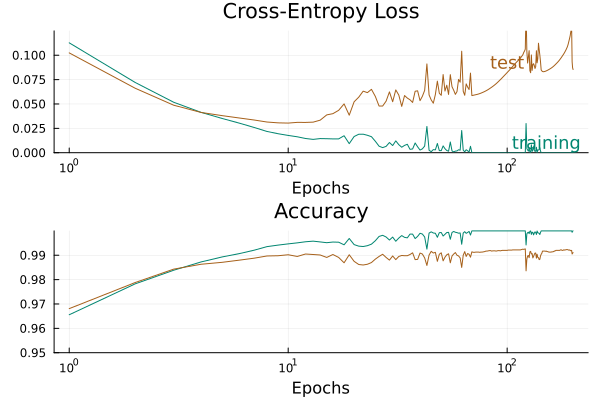

In [9]:
model = Chain(  # same as before, but resetting initial values
  Conv((3, 3), 1=>16,  pad=(1,1), relu),
  MaxPool((2,2)),
  Conv((3, 3), 16=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  Conv((3, 3), 32=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10)
  ) |> gpu

smallbatch = train_mnist!(model, X, Y, tX, tY, "conv-smallbatch";
                    loss=(x,y)->Flux.logitcrossentropy(model(x),y),
                    batchsize=128,
                    reps_per_epoch=1,
                    maxepochs=200,
                    rerun=false
                    )
@show maximum(smallbatch.acctest)
training_plot(smallbatch)

Smaller batches have improved the accuracy from 98.83% to just over
99%. Note that although the number of epochs are roughly the same as
above, the number of gradient descent iterations is much
higher. The total run-time is roughly the same.

## Data Augmentation

The example in the model zoo also augments the training data by adding
a small amount of Gaussian noise to the training images. Data
augmentation is used by the best models among the [MNIST benchmarks on
LeCun's website](http://yann.lecun.com/exdb/mnist/). For example @ciresan2010
randomly distorts images with small rotations and stretching. Adding
Gaussian noise is not as well geometrically motivated, but it has the
advantage of being very easy to implement.

We will add a $\epsilon \sim N(0, 0.1)$ to each pixel in the
images. Here is what this looks like for a few images

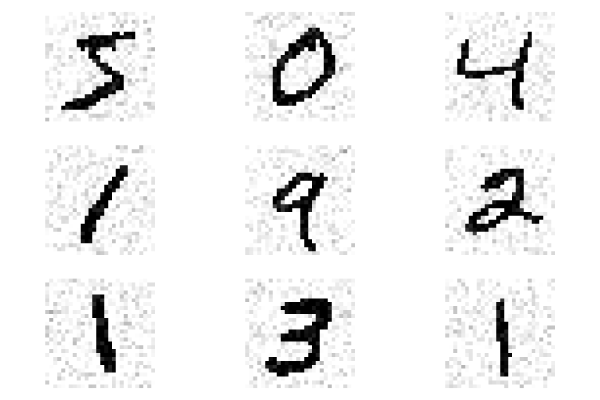

In [10]:
plot([plot(Gray.(1 .- 0.1*randn(size(imgs[i]))) .- round.(imgs[i])) for i in
      1:9]..., xlab="", ylab="", aspect_ratio=:equal, axis=false, ticks=false)

With this added noise, the digits are still easily recognizable, so we would
hope that our model can classify them.

In [11]:
addnoise(x, σ) = x .+ σ.*gpu(randn(eltype(x), size(x)))
@show accuracy(out.model, addnoise(tX,0.1f0), tY)
@show accuracy(smallbatch.model, addnoise(tX,0.1f0), tY)

LoadError: DimensionMismatch: A has dimensions (10,288) but B has dimensions (3,960000)

The models trained above do a pretty good job of classifying noisy
images, but not quite as well as the original. What if we train the
models with noise?

Here, we will train with the original large batches and added noise.

In [12]:
model = Chain(  # same as before, but resetting initial values
  Conv((3, 3), 1=>16,  pad=(1,1), relu),
  MaxPool((2,2)),
  Conv((3, 3), 16=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  Conv((3, 3), 32=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10)
) |> gpu

outn = train_mnist!(model, X, Y, tX, tY, "conv-augrandn";
                    loss=(x,y)->Flux.logitcrossentropy(model(x .+ 0.1f0*gpu(randn(eltype(x), size(x)))),y),
                    batchsize=2500,
                    reps_per_epoch=2,
                    maxepochs=200,
                    rerun=false
                    )
@show maximum(outn.acctest)

┌ Info: Beginning training loop...
└ @ Main In[6]:46


maximum(outn.acctest) = 0.9922


0.9922

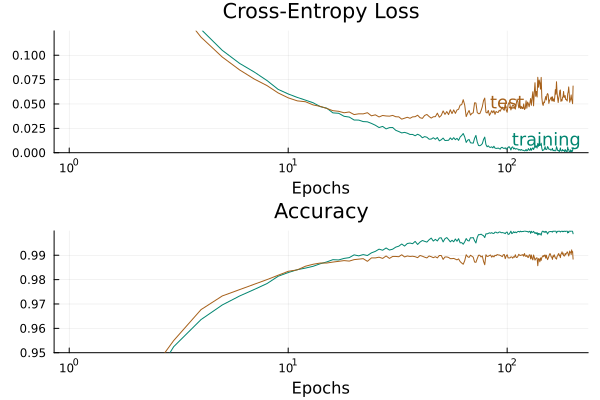

In [13]:
training_plot(outn)

With large batches, adding noise has improved the accuracy very little

## Small Batches and Data Augmentation

Let's try combining small batches and data augmentation.

┌ Info: Beginning training loop...
└ @ Main In[6]:46


maximum(smallnoisy.acctest) = 0.9934


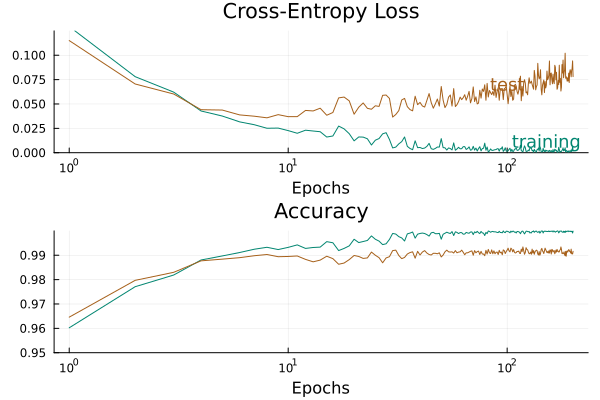

In [14]:
model = Chain(  # same as before, but resetting initial values
  Conv((3, 3), 1=>16,  pad=(1,1), relu),
  MaxPool((2,2)),
  Conv((3, 3), 16=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  Conv((3, 3), 32=>32, pad=(1,1), relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10)
) |> gpu

smallnoisy = train_mnist!(model, X, Y, tX, tY, "conv-augrandn-smallbatch";
                    loss=(x,y)->Flux.logitcrossentropy(model(x .+ 0.1f0*gpu(randn(eltype(x), size(x)))),y),
                    batchsize=128,
                    reps_per_epoch=1,
                    maxepochs=200,
                    rerun=false
                    )
@show maximum(smallnoisy.acctest)
training_plot(smallnoisy)

This gives the highest test accuracy we have achieved so far. Let's
look at some of the missclassified digits.

In [15]:
tlabels = MNIST.labels(:test)
timgs = MNIST.images(:test)
# predicted labels
mlabels = onecold(cpu(smallnoisy.model(tX))).-1
@show mean(mlabels.==tlabels) # = accuracy
@show sum(mlabels .!= tlabels)
miss=findall(mlabels .!= tlabels)
plot( [plot(timgs[i], 
            title="$(tlabels[i]) as $(mlabels[i])",
            axis=false, ticks=false,
            aspect_ratio=:equal) for i in miss[1:16]]...)

LoadError: type DataType has no field labels

## Looking inside the Black Box

Our fitted model is somewhat of a black box, but when we are working
with images and convolution, we can somewhat look inside it. We can
display the images that are generated by each convolutional and/or max
pool layer. Let's do this for one image.

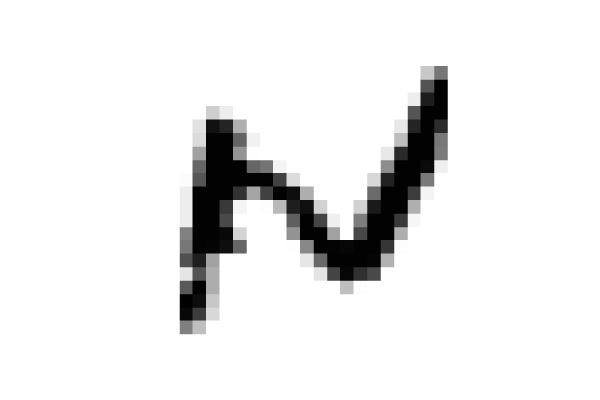

In [16]:
i = 1
m = smallnoisy.model
figs = Array{typeof(plot()), 1}(undef, 3)
j = 1
for l in 1:length(m)
  global j, figs
  if (typeof(m[l]) <: MaxPool)
    layer = m[1:l](reshape(X[:,:,:,i], 28,28,1,1))
    figs[j] = plot( [plot(Gray.(cpu(1 .- layer[:,:,c,1])), aspect_ratio=:equal,
                          axis=false, ticks=false) for c in
                     1:size(layer,3)]...)
    j += 1
  end
end
plot(Gray.(cpu(1 .- X[:,:,1,i])), aspect_ratio=:equal, axis=false,
     ticks=false)

The original is above. Below is are the output of the first
convolution + max pool layer.

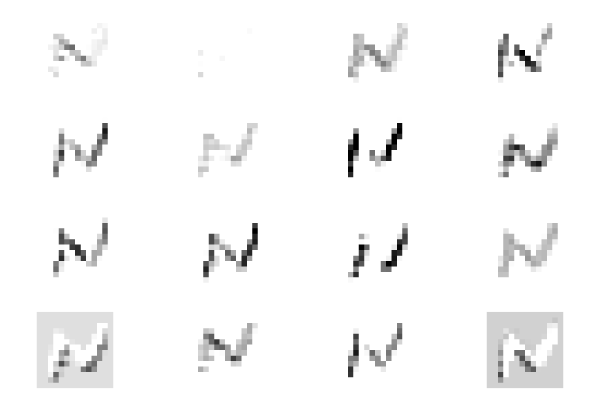

In [17]:
figs[1]

Now the second

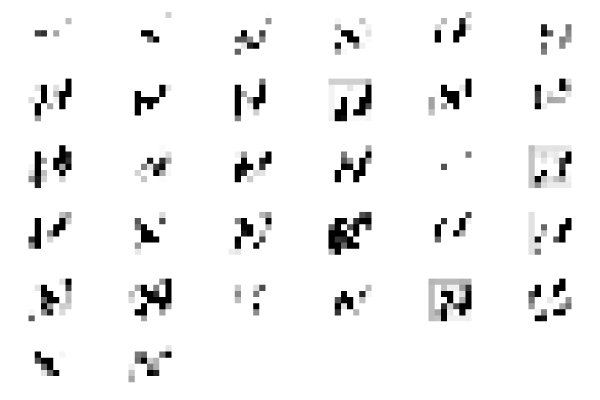

In [18]:
figs[2]

And the last

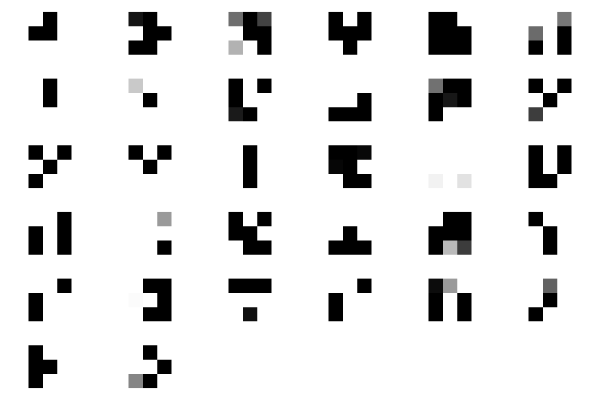

In [19]:
figs[3]

These 32 three by three images then get stacked into a vector and
passed into the final dense layer.

I'm not sure that there's much to learn from looking at these
images. Maybe it's best to keep the box closed. 





# References